## **1. Importing Required Libraries**

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray
import cv2
from skimage.data import camera
from numpy.fft import fft2, ifft2, fftshift, ifftshift

## **2. Why Does Phase Matter?**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


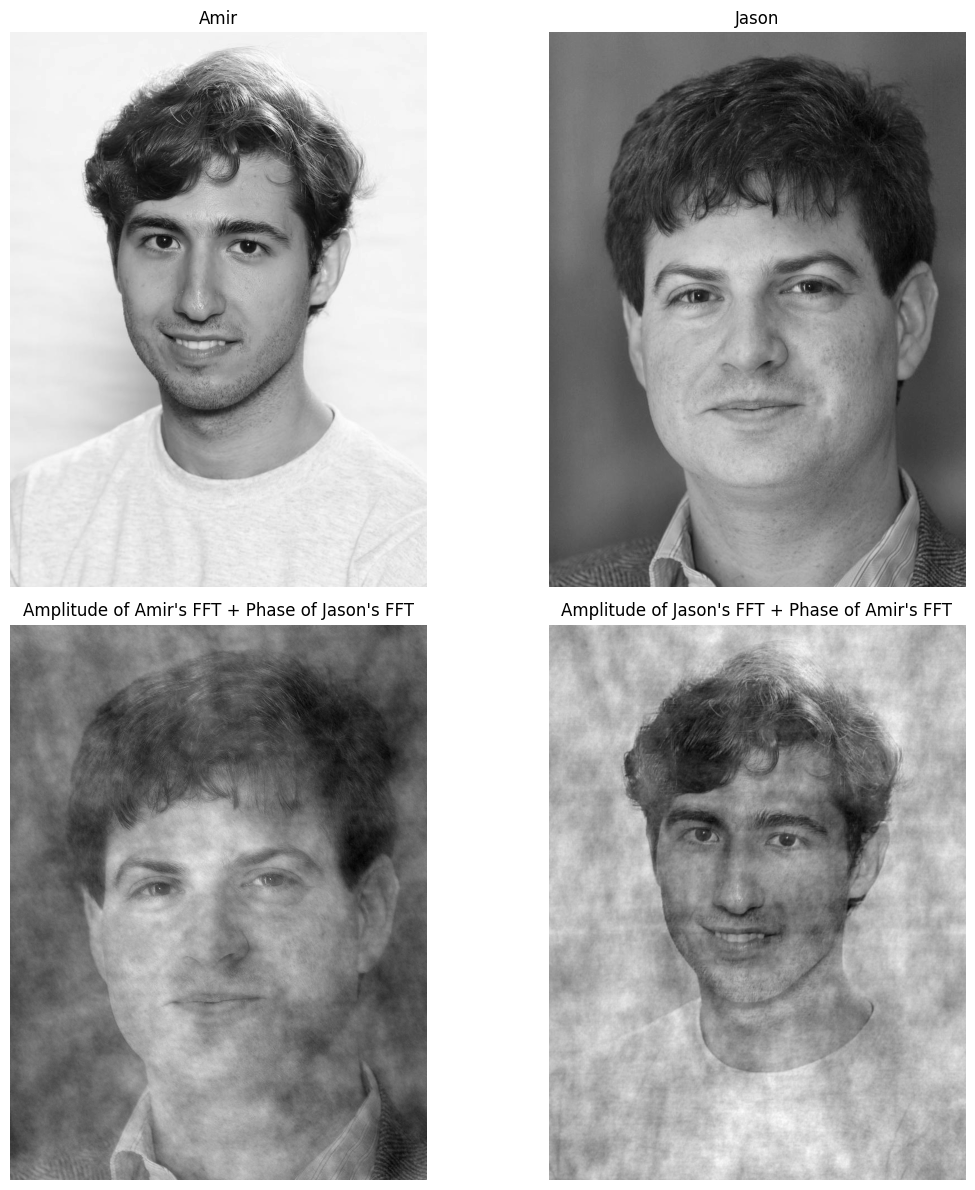

In [5]:
from google.colab import drive
import cv2

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your images in Google Drive
image1_path = '/content/drive/MyDrive/Imaging Physics Group/amir.jpg'
image2_path = '/content/drive/MyDrive/Imaging Physics Group/jason.jpg'

# Load the images using cv2
image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)


# Convert BGR to RGB
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Find the larger dimensions
max_height = max(image1.shape[0], image2.shape[0])
max_width = max(image1.shape[1], image2.shape[1])

# Resize both images to the larger dimensions
image1_resized = resize(image1, (max_height, max_width), anti_aliasing=True)
image2_resized = resize(image2, (max_height, max_width), anti_aliasing=True)

# Convert to grayscale
gray1 = rgb2gray(image1_resized)
gray2 = rgb2gray(image2_resized)

# Fourier transform of both images
fft1 = np.fft.fft2(gray1)
fft2 = np.fft.fft2(gray2)

# Extract amplitude and phase
amplitude1, phase1 = np.abs(fft1), np.angle(fft1)
amplitude2, phase2 = np.abs(fft2), np.angle(fft2)

# Reconstruct images
reconstructed1 = np.fft.ifft2(amplitude1 * np.exp(1j * phase2)).real
reconstructed2 = np.fft.ifft2(amplitude2 * np.exp(1j * phase1)).real

# Normalize reconstructed images to [0, 1] range
reconstructed1 = (reconstructed1 - reconstructed1.min()) / (reconstructed1.max() - reconstructed1.min())
reconstructed2 = (reconstructed2 - reconstructed2.min()) / (reconstructed2.max() - reconstructed2.min())

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# First row - original images
axes[0, 0].imshow(gray1, cmap="gray")
axes[0, 0].set_title("Amir")
axes[0, 0].axis("off")

axes[0, 1].imshow(gray2, cmap="gray")
axes[0, 1].set_title("Jason")
axes[0, 1].axis("off")

# Second row - reconstructed images
axes[1, 0].imshow(reconstructed1, cmap='gray')
axes[1, 0].set_title("Amplitude of Amir's FFT + Phase of Jason's FFT")
axes[1, 0].axis("off")

axes[1, 1].imshow(reconstructed2, cmap='gray')
axes[1, 1].set_title("Amplitude of Jason's FFT + Phase of Amir's FFT")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

## **3. Phase Retrieval Algorithm**

### **3.1. Required Functions**

In [27]:
def phase_retrieval(magnitude, support, beta=0.9, max_iter=1000, method='HIO'):
    """
    Perform Fourier phase retrieval using the HIO or ER method.

    Parameters:
        magnitude: 2D numpy array
            Fourier magnitude of the original image.
        support: 2D numpy array
            Binary mask defining the support constraint.
        beta: float, optional
            Feedback parameter for HIO (default: 0.9).
        max_iter: int, optional
            Number of iterations (default: 1000).

    Returns:
        2D numpy array
            Reconstructed image.
    """
    # Initialize random phase and Fourier guess
    phase = np.exp(1j * 2 * np.pi * np.random.rand(*magnitude.shape))
    G = magnitude * phase  # Initial guess in Fourier space
    g_prev = np.zeros_like(magnitude, dtype=np.complex64)

    output_each_iter = []

    for _ in range(max_iter):
        # Transform to spatial domain
        g = np.real(ifft2(ifftshift(G)))

        # Apply support constraint
        if method == 'HIO':
            g_new = np.where(support, g, g_prev - beta * g)
        elif method == 'ER':
            g_new = np.where(support, g, 0)

        # Enforce magnitude constraint in Fourier domain
        G = fftshift(fft2(g_new))
        G = magnitude * np.exp(1j * np.angle(G))

        # Save current reconstruction
        output_each_iter.append(np.real(ifft2(ifftshift(G))))

        # Update previous spatial domain image
        g_prev = g_new

    return output_each_iter


In [9]:
def zero_pad_image(image):
    # Original dimensions
    original_height, original_width = image.shape

    # New dimensions
    new_height, new_width = original_height * 2, original_width * 2

    # Create zero-padded matrix
    padded_image = np.zeros((new_height, new_width))

    # Calculate start and end indices for centering the image
    start_h = (new_height - original_height) // 2
    start_w = (new_width - original_width) // 2

    # Place the original image in the center
    padded_image[start_h:start_h + original_height, start_w:start_w + original_width] = image

    # Create the support matrix
    support_matrix = np.zeros_like(padded_image)
    support_matrix[start_h:start_h + original_height, start_w:start_w + original_width] = 1

    return padded_image, support_matrix

In [22]:
def crop_padded_image(padded_image, original_shape):
    # Extract the original dimensions
    original_height, original_width = original_shape

    # Calculate the start and end indices for cropping the image
    start_h = (padded_image.shape[0] - original_height) // 2
    start_w = (padded_image.shape[1] - original_width) // 2

    # Crop the padded image to the original size
    cropped_image = padded_image[start_h:start_h + original_height, start_w:start_w + original_width]

    return cropped_image


### **3.2. Loading Cameraman**

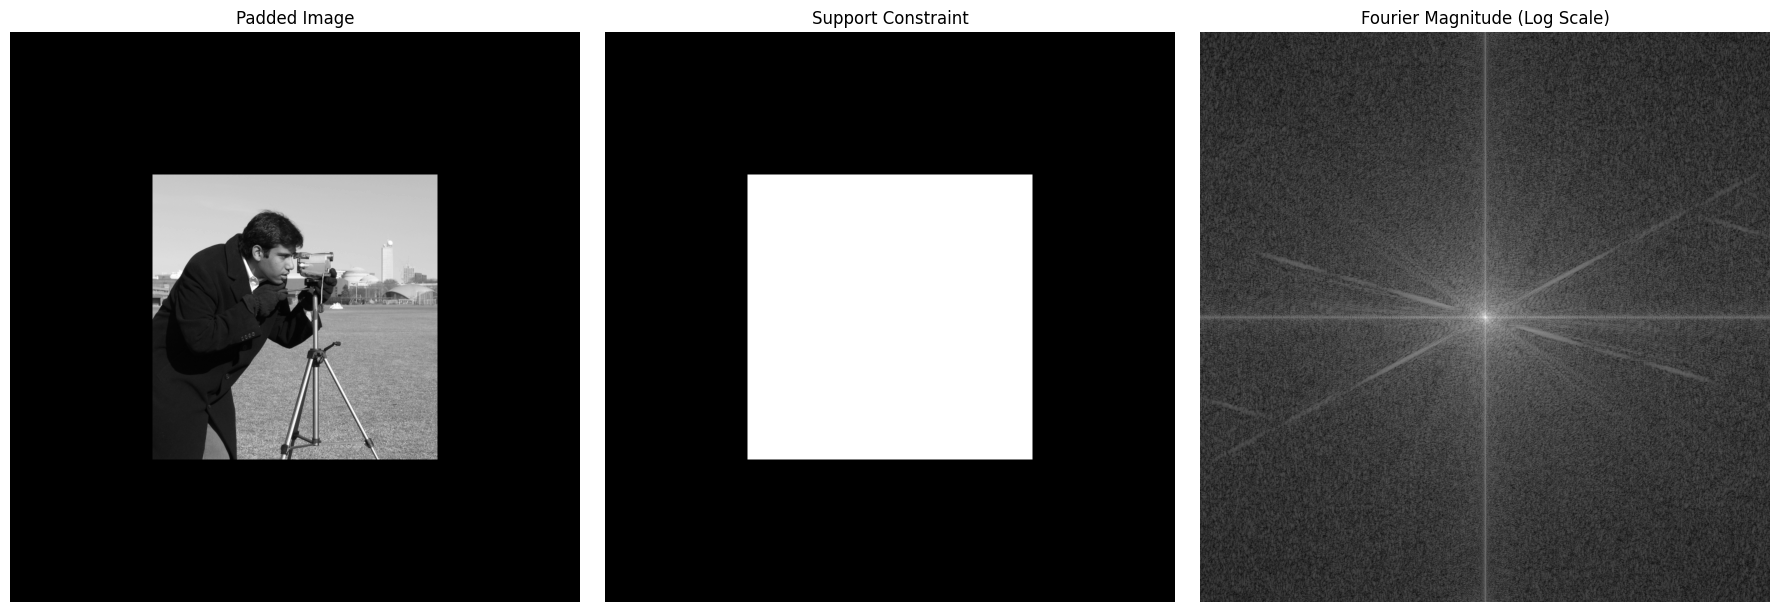

In [17]:
# Load the Cameraman image
image = camera().astype(np.float32)
image /= np.max(image)  # Normalize the image

# Apply zero-padding and create the support matrix
padded_image, support_matrix = zero_pad_image(image)

# Generate the Fourier magnitude
fourier_transform = fftshift(fft2(padded_image))
magnitude = np.abs(fourier_transform)

# Plot the padded image, support matrix, and Fourier magnitude
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(padded_image, cmap='gray')
axes[0].set_title('Padded Image')
axes[0].axis('off')

axes[1].imshow(support_matrix, cmap='gray')
axes[1].set_title('Support Constraint')
axes[1].axis('off')

# Fourier Magnitude in logarithmic scale for better visualization
axes[2].imshow(np.log1p(magnitude), cmap='gray')
axes[2].set_title('Fourier Magnitude (Log Scale)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### **3.3. Performing ER and HIO on cameraman iamge**

In [18]:
# Apply ER
reconstructed_image_ER = phase_retrieval(magnitude, support_matrix, beta=0.99, max_iter=1000, method='ER')

# Apply HIO
reconstructed_image_HIO = phase_retrieval(magnitude, support_matrix, beta=0.99, max_iter=1000, method='HIO')

### **3.4. Visualization of Final Results**

Shape of Reconstructed Image (ER): (1000, 1024, 1024)
Shape of Reconstructed Image (HIO): (1000, 1024, 1024)


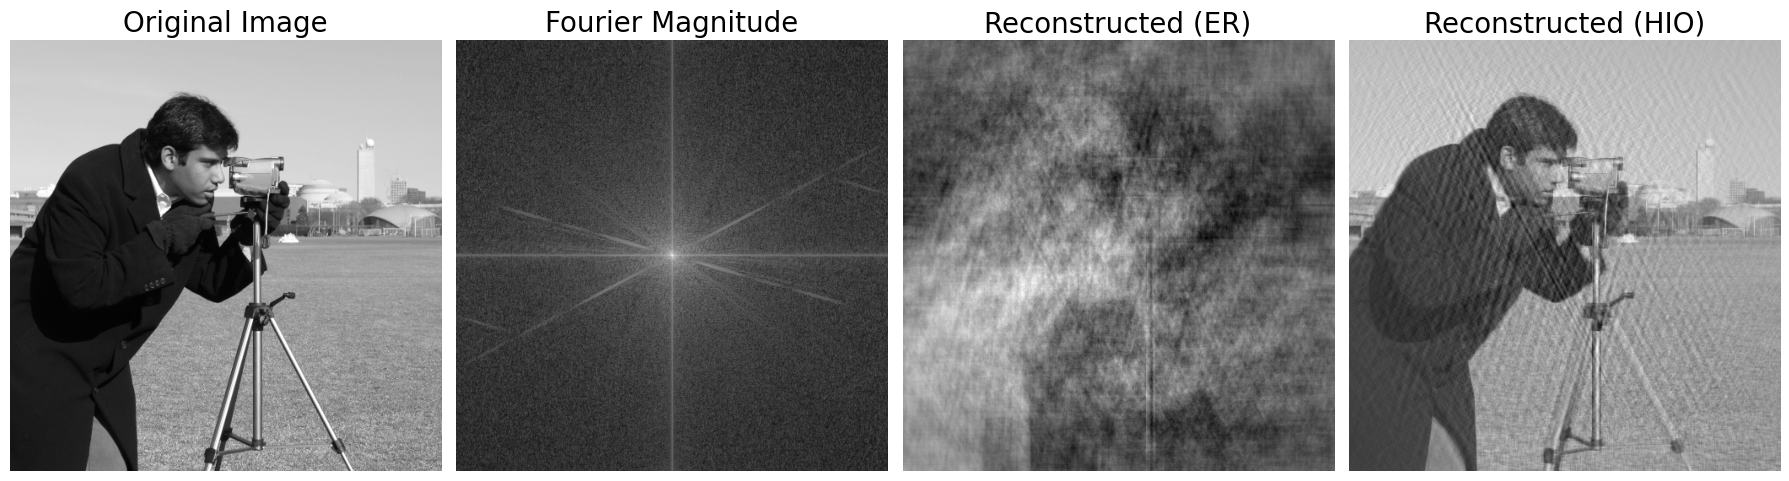

In [25]:
# Convert reconstructed images to NumPy arrays (if not already)
reconstructed_image_ER = np.asarray(reconstructed_image_ER)
reconstructed_image_HIO = np.asarray(reconstructed_image_HIO)

# Print shapes of reconstructed images
print("Shape of Reconstructed Image (ER):", reconstructed_image_ER.shape)
print("Shape of Reconstructed Image (HIO):", reconstructed_image_HIO.shape)

# Define the original image shape (before padding)
font_size = 20
original_shape = image.shape

# Plot results
plt.figure(figsize=(18, 6))

# Plot Original Image
plt.subplot(1, 4, 1)
plt.title("Original Image", fontsize = font_size)
plt.imshow(image, cmap='gray')
plt.axis('off')

# Plot Fourier Magnitude
plt.subplot(1, 4, 2)
plt.title("Fourier Magnitude", fontsize = font_size)
plt.imshow(np.log1p(magnitude), cmap='gray')  # Use np.log1p for numerical stability
plt.axis('off')

# Plot Reconstructed Image (ER)
plt.subplot(1, 4, 3)
plt.title("Reconstructed (ER)", fontsize = font_size)
# Crop the image back to its original shape
cropped_ER = crop_padded_image(reconstructed_image_ER[-1], original_shape)
plt.imshow(cropped_ER, cmap='gray')
plt.axis('off')

# Plot Reconstructed Image (HIO)
plt.subplot(1, 4, 4)
plt.title("Reconstructed (HIO)", fontsize = font_size)
# Crop the image back to its original shape
cropped_HIO = crop_padded_image(reconstructed_image_HIO[-1], original_shape)
plt.imshow(cropped_HIO, cmap='gray')
plt.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


### **3.5. Making Video**

In [26]:
# Define video settings
output_file = 'reconstructed_video.mp4'
fps = 30  # Frames per second
frame_size = (512 * 2, 512 * 2)  # 2 by 2 subplot layout

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
video_writer = cv2.VideoWriter(output_file, fourcc, fps, frame_size, isColor=True)

# Define the original image shape (before padding)
original_shape = image.shape

# Generate video frames
for i in range(len(reconstructed_image_ER)):
    # Create a figure for the current iteration
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # Plot Original Image
    axs[0, 0].imshow(image, cmap='gray')
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis('off')

    # Plot Fourier Magnitude
    axs[0, 1].imshow(np.log1p(magnitude), cmap='gray')  # Use np.log1p for numerical stability
    axs[0, 1].set_title("Fourier Magnitude")
    axs[0, 1].axis('off')

    # Plot Reconstructed Image (ER)
    cropped_ER = crop_padded_image(reconstructed_image_ER[i], original_shape)  # Crop the image
    axs[1, 0].imshow(cropped_ER, cmap='gray')
    axs[1, 0].set_title(f"Reconstructed (ER)\nIteration {i + 1}")
    axs[1, 0].axis('off')

    # Plot Reconstructed Image (HIO)
    cropped_HIO = crop_padded_image(reconstructed_image_HIO[i], original_shape)  # Crop the image
    axs[1, 1].imshow(cropped_HIO, cmap='gray')
    axs[1, 1].set_title(f"Reconstructed (HIO)\nIteration {i + 1}")
    axs[1, 1].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Save figure as an image in memory
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

    # Resize the frame to match video dimensions
    frame = cv2.resize(frame, frame_size)

    # Write frame to video
    video_writer.write(frame)

    # Close the figure to free memory
    plt.close(fig)

# Release video writer
video_writer.release()

print(f"Video saved as {output_file}")

<ipython-input-26-d2f44346ac29>:45: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Video saved as reconstructed_video.mp4
